In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [24]:
loss = pd.read_csv('./train_loss.csv', names=['iter', 'loss'], usecols=[1])['loss']

In [42]:
new_loss = loss / pd.Series(np.linspace(1, 2, 418))

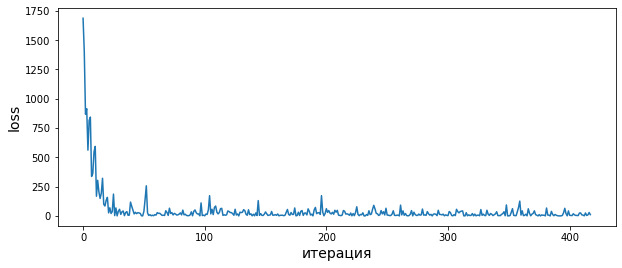

In [77]:
plt.figure(figsize=(10, 4))
plt.plot(new_loss)
plt.ylabel('loss', fontsize='14')
plt.xlabel('итерация', fontsize='14')
plt.savefig('train_loss.png')

In [45]:
tel = pd.read_csv('../data/PdM_telemetry.csv',
                            parse_dates=['datetime'],
                            infer_datetime_format=True,
                            low_memory=False,
                            error_bad_lines=False,
                            )

b'Skipping line 92490: expected 6 fields, saw 9\n'


In [47]:
failures = pd.read_csv('../data/PdM_failures.csv',
                           parse_dates=['datetime'],
                           infer_datetime_format=True,
                           error_bad_lines=False,
                           )

In [48]:
tf = tel.merge(failures, on=['machineID', 'datetime'], how='left').fillna(0)

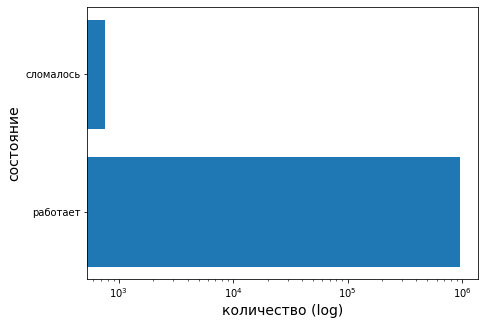

In [78]:
vals = [len(tel) - len(failures), len(failures)]
names = ['работает', 'сломалось']

plt.figure(figsize=(7, 5))
plt.barh(names, vals, log=True)
plt.ylabel('состояние', fontsize='14')
plt.xlabel('количество (log)', fontsize='14')
plt.savefig('distr.png')

In [84]:
val_loss = pd.read_csv('./val_loss.csv', names=['iter', 'loss'], usecols=[1])['loss']

In [99]:
new_val = val_loss / np.linspace(1, 5, 8)

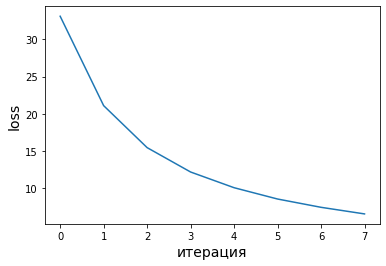

In [100]:
plt.figure(figsize=(6, 4))
plt.plot(new_val)
plt.ylabel('loss', fontsize='14')
plt.xlabel('итерация', fontsize='14')
plt.savefig('val_loss.png')

In [17]:
from argparse import ArgumentParser
from catboost import CatBoostClassifier, Pool
from catboost.utils import get_roc_curve
import torch
from pytorch_lightning import LightningModule

from main.datamodules import TelemetryDataModule
from main.models import LSTM
from main.utils import get_gbm_database, get_lstm_feature

In [6]:
X, y = get_gbm_database('./data/PdM_telemetry.csv',
                            './data/PdM_maint.csv',
                            './data/PdM_machines.csv',
                            './data/PdM_errors.csv',
                            './data/PdM_failures.csv',
                            seq_len=8,
                            machine_id=14,
                            )
X_gbm = X.iloc[24:-8]
y_target = y.iloc[24:-8]

dm = TelemetryDataModule(path='./data/PdM_telemetry.csv',
                            seq_len=24,
                            out_seq_len=8,
                            batch_size=X_gbm.shape[0],
                            num_workers=8,)
dm.setup(stage="prodaction")
X_lstm = dm.prodaction_dataset()

b'Skipping line 92490: expected 6 fields, saw 9\n'


In [7]:
cat = CatBoostClassifier()
cat.load_model('./model_checkpoints/gbm.cbm')

In [9]:
lstm = LSTM.load_from_checkpoint('./model_checkpoints/lstm.ckpt',
                                     n_features=1,
                                     hidden_size=100,
                                     seq_len=24,
                                     out_seq_len=8,
                                     batch_size=X_gbm.shape[0],
                                     criterion=torch.nn.MSELoss(),
                                     num_layers=1,
                                     dropout=0,
                                     learning_rate=3e-4,
                                     )
lstm.freeze()

In [11]:
y_hat_lstm = None
for (x, _) in X_lstm:
    y_hat_lstm = lstm(x)

X_gbm = get_lstm_feature(X_gbm, y_hat_lstm)

In [19]:
pool_train = Pool(X_gbm.drop(columns=['lstm_mean', 'lstm_std']), y_target)

In [23]:
new_cat = CatBoostClassifier(
    iterations=5000,
    learning_rate=1e-2
)

In [24]:
new_cat.fit(pool_train)

	learn: 0.0001741	total: 35.1s	remaining: 2.87s
4622:	learn: 0.0001741	total: 35.1s	remaining: 2.86s
4623:	learn: 0.0001741	total: 35.1s	remaining: 2.85s
4624:	learn: 0.0001741	total: 35.1s	remaining: 2.85s
4625:	learn: 0.0001741	total: 35.1s	remaining: 2.84s
4626:	learn: 0.0001741	total: 35.1s	remaining: 2.83s
4627:	learn: 0.0001741	total: 35.1s	remaining: 2.82s
4628:	learn: 0.0001741	total: 35.1s	remaining: 2.81s
4629:	learn: 0.0001741	total: 35.1s	remaining: 2.81s
4630:	learn: 0.0001741	total: 35.1s	remaining: 2.8s
4631:	learn: 0.0001741	total: 35.1s	remaining: 2.79s
4632:	learn: 0.0001741	total: 35.2s	remaining: 2.78s
4633:	learn: 0.0001741	total: 35.2s	remaining: 2.78s
4634:	learn: 0.0001741	total: 35.2s	remaining: 2.77s
4635:	learn: 0.0001741	total: 35.2s	remaining: 2.76s
4636:	learn: 0.0001741	total: 35.2s	remaining: 2.75s
4637:	learn: 0.0001741	total: 35.2s	remaining: 2.75s
4638:	learn: 0.0001741	total: 35.2s	remaining: 2.74s
4639:	learn: 0.0001741	total: 35.2s	remaining: 2.73s

In [25]:
X_test, y_test = get_gbm_database('./data/PdM_telemetry.csv',
                            './data/PdM_maint.csv',
                            './data/PdM_machines.csv',
                            './data/PdM_errors.csv',
                            './data/PdM_failures.csv',
                            seq_len=8,
                            machine_id=34,
                            )
X_gbm_test = X_test.iloc[24:-8]
y_target_test = y_test.iloc[24:-8]

b'Skipping line 92490: expected 6 fields, saw 9\n'


In [26]:
pool_test = Pool(X_gbm_test.drop(columns=['lstm_mean', 'lstm_std']), y_target_test)

In [44]:
(fpt_, tpr_, treshholds_) = get_roc_curve(new_cat, pool_test)
(fpt, tpr, treshholds) = get_roc_curve(cat, pool)

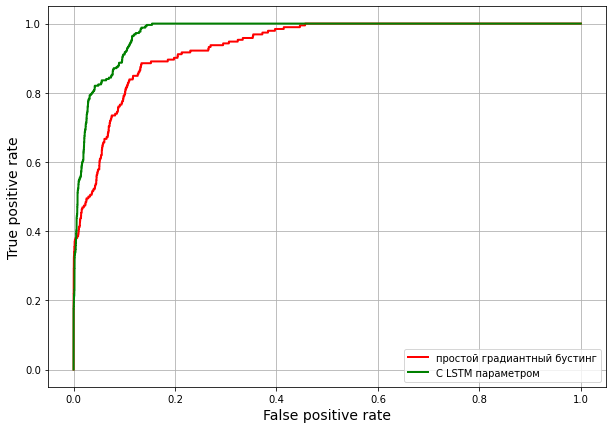

In [80]:
plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(fpt_, tpr_, 'r', linewidth=2, label='простой градиантный бустинг')
plt.plot(fpt, tpr, 'g', linewidth=2, label='C LSTM параметром')
plt.legend(loc='lower right')
plt.ylabel('True positive rate', fontsize='14')
plt.xlabel('False positive rate', fontsize='14')
plt.savefig('./notebooks/rocs.png')

In [78]:
mu, sigma = 0.5, 0.01
s = np.random.normal(mu, sigma, 1000)

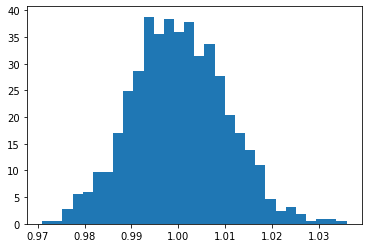

In [79]:
count, bins, ignored = plt.hist(s, 30, density=True)

In [73]:
count

array([0.00398179, 0.        , 0.00796359, 0.01592718, 0.01194538,
       0.03583615, 0.0676905 , 0.08759947, 0.13538101, 0.17918074,
       0.25881663, 0.27076201, 0.37428866, 0.33845252, 0.4220702 ,
       0.32650713, 0.35437969, 0.31456175, 0.24687125, 0.21501689,
       0.11547203, 0.07963589, 0.03981794, 0.04379974, 0.01194538,
       0.00796359, 0.01194538, 0.        , 0.        , 0.00398179])